In [8]:
import numpy as np
import xarray as xr

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
matplotlib.rcParams.update({'font.size':15})
import time

from linearWaveModels import linear_w_1layer,linear_w_2layer,linear_w_generalized,w_to_zeta,w_to_Tprime

xr.set_options(display_style='text') 

In [2]:
from scipy.integrate import cumtrapz
def plot_streamlines(ax,w,Uz,**plt_kwargs):
    zeta = w_to_zeta(w,Uz)
    for zi in np.linspace(0,9,13):
        ax.plot(w.distance_from_mtn,zi+zeta.sel(altitude=zi,method='nearest'),**plt_kwargs)

We now solve for the linear mountain wave equation with arbitrary wind & static stability:

$$(\partial_z^2 + \partial_x^2)w + l(z)^2 w =0 ~~~~\textrm{where } l(z)^2 := \dfrac{N^2}{U^2}-\dfrac{1}{U}\dfrac{\mathrm{d}^2U}{\mathrm{d}z^2}$$

or, when writing $w(x,z) = \int_{-\infty}^{+\infty}\hat{w}(k,z)e^{ikx}\mathrm{d}k$, 
$$\partial_z^2\hat w + (l(z)^2 - k^2)\hat w =0$$
The lower BC is $\hat w(k,0) = ikU(z=0)\hat h(k)$, and upper BC (from Durran et al 2014) is $\dfrac{\mathrm{d}\hat w}{\mathrm{d}z}(k,z_{top}) - im_{top} \hat w(k,z_{top}) = 0$, where $m_{top}=\sqrt{l(z_{top})^2 - k^2}$, assuming one always has $l(z_{top})^2 > k^2$

We discretize the problem on a uniform z grid.

In [4]:
z=np.linspace(0,9e3,100)
xx = np.arange(-250e3,250.1e3,2e2)
U=10;Nl=0.01047;Nu=Nl*0.24/0.6;H=3000
a=5e3;A=0.6*U/Nl
hx = A*a**2/(xx**2+a**2)
x0 = 8771*20.3
hx_destructive_general = A*a**2/(xx**2+a**2) + A*a**2/((xx-x0)**2+a**2)
x0 = 8613.26*20.44
hx_destructive_2layer = A*a**2/(xx**2+a**2) + A*a**2/((xx-x0)**2+a**2)

In [5]:
Uz0 = U*z**0
Nz0 = (z<H)*Nl + (z>=H)*Nu
%time w_general   = linear_w_generalized(xx,hx,z,Uz0,Nz0)
%time w_general_destructive   = linear_w_generalized(xx,hx_destructive_general,z,Uz0,Nz0)

0 500 1000 1500 2000 2500 CPU times: user 1.71 s, sys: 1.57 s, total: 3.28 s
Wall time: 3.93 s
0 500 1000 1500 2000 2500 CPU times: user 1.58 s, sys: 557 ms, total: 2.14 s
Wall time: 2.3 s


In [6]:
w_2layer = linear_w_2layer(xx,hx,z,H,U,U,Nl,Nu)
w_2layer_destructive = linear_w_2layer(xx,hx_destructive_2layer,z,H,U,U,Nl,Nu)

(0.0, 0.015)

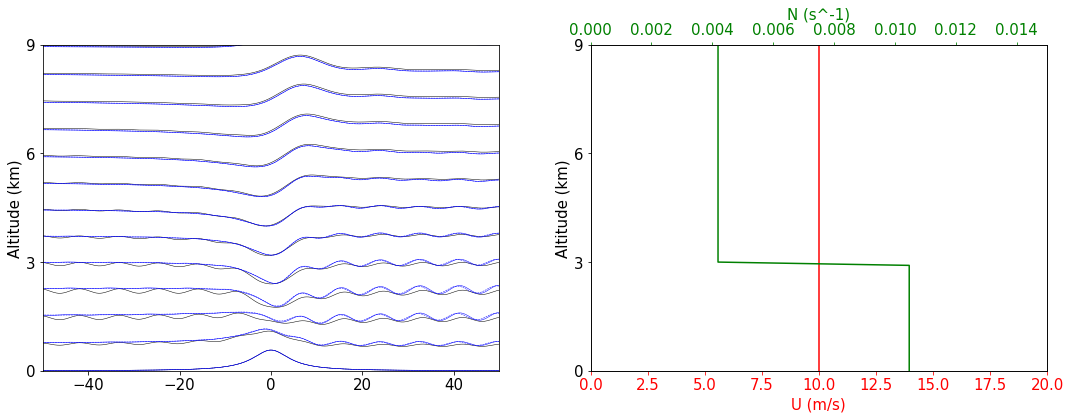

In [9]:
_,(ax1,ax2)=plt.subplots(1,2,figsize=(18,6));ax22=ax2.twiny()

plot_streamlines(ax1,w_general,10,color='k',linewidth=0.5)
plot_streamlines(ax1,w_general_destructive,10,color='b',linewidth=0.5)

#plot_streamlines(ax1,w_2layer,10,color='k',linewidth=0.5,linestyle='--')
plot_streamlines(ax1,w_2layer_destructive,10,color='b',linewidth=0.5,linestyle='--')

ax2.plot(Uz0,z/1e3,color='red')
ax22.plot(Nz0,z/1e3,color='green')

ax2.tick_params(axis='x', colors='r'); ax2.set_xlabel('U (m/s)',color='r')
ax22.tick_params(axis='x', colors='g');ax22.set_xlabel('N (s^-1)',color='g')
for ax in ax1,ax2:
    ax.set_yticks((0,3,6,9))
    ax.set_ylim(0,9)
    ax.set_ylabel("Altitude (km)")
    
ax1.set_xlim(-50,50)
ax2.set_xlim(0,20)
ax22.set_xlim(0,0.015)

(-100.0, 100.0)

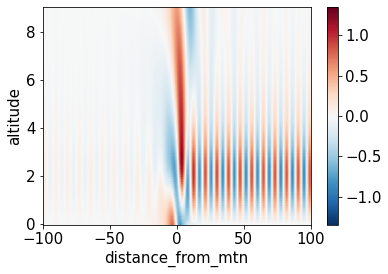

In [10]:
w_general_destructive.plot(y='altitude')
plt.xlim(-100,100)

(-100.0, 100.0)

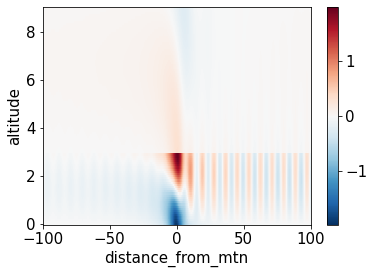

In [11]:
w_to_Tprime(w_general_destructive,Uz0,Nz0).plot(y='altitude')
plt.xlim(-100,100)

(-100.0, 100.0)

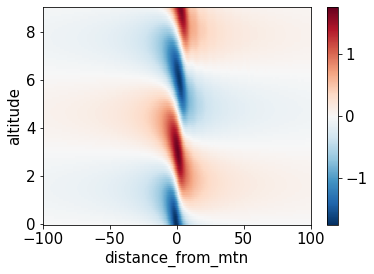

In [12]:
w_test = linear_w_1layer(xx,hx,z,10,0.01)
w_to_Tprime(w_test,10,0.01).plot(y='altitude')
plt.xlim(-100,100)

In [19]:
import matplotlib.pyplot as plt
import xarray as xr
xr.set_options(display_style='text')

(1500.0, 2000.0)

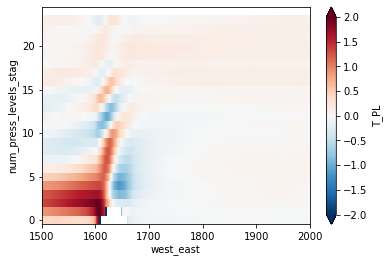

In [22]:
test = xr.open_dataset('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.9mps.3km/diags/wrf.T_PL.days50-400.nc').T_PL
test=test.where(test>200)
(test-test.isel(west_east=3000)).plot(vmin=-2,vmax=2,cmap=plt.cm.RdBu_r)
plt.xlim(1500,2000)